In [362]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy

from qcal.modelconstruction.models import *
from qcal.modelconstruction.experiment_design import *
from qcal.phase_estimation.analysis import *

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [363]:
xvec = np.array([0.174, 0.31, -0.328])
depths = [2**i for i in range(10)]
num_shots = 1000

In [364]:
edesign = EDesign_CZ(depths, ('Q0', 'Q1'))
target_model = create_CZ_model(np.zeros(3))
noise_model = create_CZ_model(xvec)
ds = edesign.make_dataset(noise_model, num_shots)
analysis = Analaysis_CZ(ds, edesign)
analysis.estimates

array([ 0.17400183,  0.31001546, -0.32801847])

# Krigging a control model

In [353]:
def control_model(param1, param2, coefs):
    return coefs[0] + coefs[1]*param1 + coefs[2]*param2 + coefs[3]*param1*param2

Text(0.5, 0, 'control')

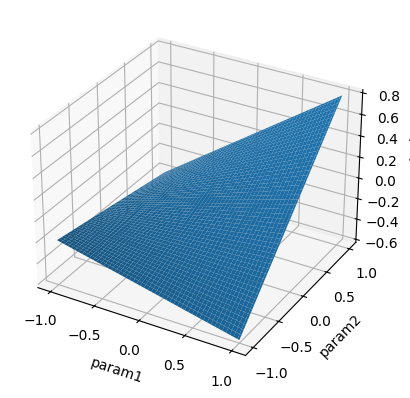

In [355]:
# make a two dimensional plot of the control model for fixed coefs
coefs = [-0.1, 0.2, 0.3, 0.4]
param1 = np.linspace(-1, 1, 100)
param2 = np.linspace(-1, 1, 100)
param1, param2 = np.meshgrid(param1, param2)
control = control_model(param1, param2, coefs)
# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(param1, param2, control)
ax.set_xlabel('param1')
ax.set_ylabel('param2')
ax.set_zlabel('control')

In [359]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm  # Import the norm object

def f(x, y):  # Your function here
  """
  This is where you define your function f(x, y).
  Replace this with your actual function. 
  """
  # Example:
  return control_model(x, y, coefs)

def expected_improvement(x, gp, target=0, xi=0.01):
  """
  Calculates the Expected Improvement acquisition function.

  Args:
    x: Point to evaluate.
    gp: GaussianProcessRegressor model.
    target: Target value (z_target).
    xi: Exploration-exploitation trade-off parameter.

  Returns:
    Expected improvement at x.
  """
  x = np.atleast_2d(x)
  mu, sigma = gp.predict(x, return_std=True)
  with np.errstate(divide='warn'):
    imp = mu - target - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)  # Use norm.cdf and norm.pdf
    ei[sigma == 0.0] = 0.0
  return -ei[0]  # Negative because we minimize

# Initial data
X = np.random.rand(5, 2)  # 5 initial random points in [0, 1]
y = np.array([f(x[0], x[1]) for x in X])

# Define the GPR kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# Create the GPR model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Optimization loop
n_iterations = 20 
for i in range(n_iterations):
  # Fit the GPR model
  gp.fit(X, y)

  # Define the bounds for the optimizer
  bounds = [(0, 1), (0, 1)]

  # Find the next point to evaluate
  result = minimize(expected_improvement, 
                    x0=np.random.rand(2), 
                    bounds=bounds, 
                    args=(gp, 0)) 
  x_new = result.x

  # Evaluate the true function
  y_new = f(x_new[0], x_new[1])

  # Update the data
  X = np.vstack([X, x_new])
  y = np.append(y, y_new)

  print(f"Iteration {i+1}: x = {x_new}, f(x) = {y_new}")

# Find the best solution found
best_index = np.argmin(np.abs(y))
best_x = X[best_index]
print(f"\nBest solution: x = {best_x}, f(x) = {y[best_index]}")

Iteration 1: x = [1. 1.], f(x) = 0.8
Iteration 2: x = [1. 1.], f(x) = 0.8
Iteration 3: x = [1. 1.], f(x) = 0.8
Iteration 4: x = [1. 1.], f(x) = 0.8


/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Iteration 5: x = [1. 1.], f(x) = 0.8
Iteration 6: x = [1. 1.], f(x) = 0.8
Iteration 7: x = [1. 1.], f(x) = 0.8


/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Iteration 8: x = [1. 1.], f(x) = 0.8
Iteration 9: x = [1. 1.], f(x) = 0.8


/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Iteration 10: x = [1. 1.], f(x) = 0.8
Iteration 11: x = [1. 1.], f(x) = 0.8
Iteration 12: x = [1. 1.], f(x) = 0.8


/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Iteration 13: x = [1. 1.], f(x) = 0.8
Iteration 14: x = [1. 1.], f(x) = 0.8
Iteration 15: x = [1. 1.], f(x) = 0.8


/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Iteration 16: x = [1. 1.], f(x) = 0.8
Iteration 17: x = [1. 1.], f(x) = 0.8
Iteration 18: x = [1. 1.], f(x) = 0.8


/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Iteration 19: x = [1. 1.], f(x) = 0.8
Iteration 20: x = [1. 1.], f(x) = 0.8

Best solution: x = [0.14350999 0.76064477], f(x) = 0.2005594774059577


In [361]:
import numpy as np
import GPy
from GPy.kern import RBF
from GPy.models import GPRegression
from GPy.acquisitions import ExpectedImprovement
from scipy.optimize import minimize

def f(x, y):  # Your function here
  """
  This is where you define your function f(x, y).
  Replace this with your actual function. 
  """
  # Example:
  return x**2 + y**2 - 0.5 

# Initial data
X = np.random.rand(5, 2)  # 5 initial random points in [0, 1]
y = np.array([f(x[0], x[1]) for x in X]).reshape(-1, 1)  # Reshape for GPy

# Define the GPR kernel
kernel = RBF(input_dim=2, variance=1.0, lengthscale=1.0)

# Create the GPR model
gp = GPRegression(X, y, kernel)

# Create the Expected Improvement acquisition function
acquisition = ExpectedImprovement(model=gp, jitter=0.01) 

# Optimization loop
n_iterations = 20 
for i in range(n_iterations):
  # Optimize the GPR model hyperparameters
  gp.optimize_restarts(num_restarts=10) 

  # Define the bounds for the optimizer
  bounds = [(0, 1), (0, 1)]

  # Find the next point to evaluate
  result = minimize(acquisition.acquisition_function, 
                    x0=np.random.rand(2), 
                    bounds=bounds) 
  x_new = result.x

  # Evaluate the true function
  y_new = f(x_new[0], x_new[1])

  # Update the data
  X = np.vstack([X, x_new])
  y = np.append(y, y_new).reshape(-1, 1)  # Reshape for GPy

  # Update the GPR model with the new data
  gp.set_XY(X, y) 

  print(f"Iteration {i+1}: x = {x_new}, f(x) = {y_new}")

# Find the best solution found
best_index = np.argmin(np.abs(y))
best_x = X[best_index]
print(f"\nBest solution: x = {best_x}, f(x) = {y[best_index]}")

[autoreload of scipy.sparse._dok failed: Traceback (most recent call last):
  File "/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jpmarceaux/anaconda3/envs/qcal/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/jpmarceaux/anaconda3/envs/qcal/lib/python3

ModuleNotFoundError: No module named 'GPy.acquisitions'